In [1]:
suppressMessages(library("rwwa"))

In [2]:
df = merge(read.table("ts_sudan.dat", col.names = c("year", "pr")), read.table("gmst.dat", col.names = c("year", "gmst")))

# set factual & counterfactual covariates
cov_f <- df[df$year == 2024,"gmst",drop = F]
cov_cf <- rbind("pi" = cov_f - 1.3)

# fit statistical model
mdl_shift <- fit_ns("gev", "shift", df, "pr", c("gmst"))
mdl_fixeddisp <- fit_ns("gev", "fixeddisp", df, "pr", c("gmst"))
mdl_shiftscale <- fit_ns("gev", "shiftscale", df, "pr", c("gmst"))

# use extRemes package to fit shift+scale model
mdl_gev_ss_auto <- fevd(df$pr, df, location.fun = ~gmst, scale.fun = ~gmst)

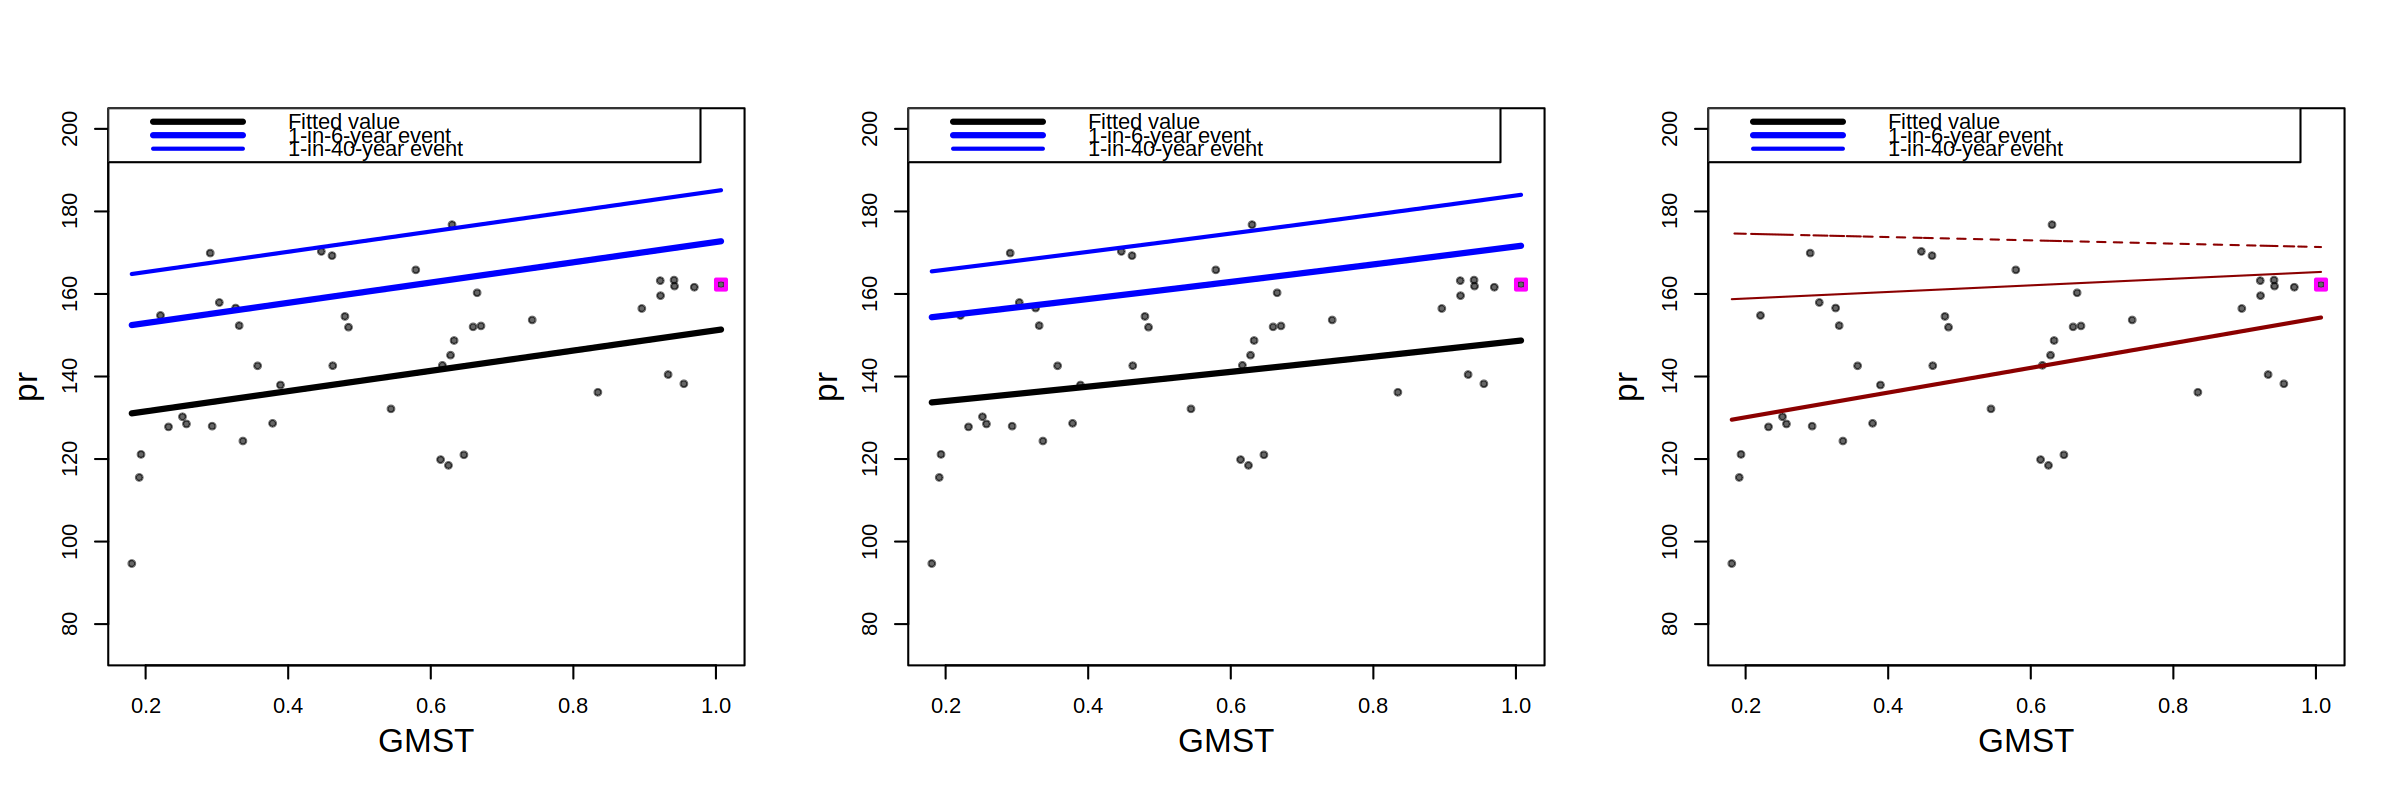

In [3]:
prep_window(c(1,3))
ylim <- c(75,200)

plot_covtrend(mdl_shift, "gmst", ylim = ylim)
plot_covtrend(mdl_fixeddisp, "gmst", ylim = ylim)
plot_covtrend(mdl_shiftscale, "gmst", ylim = ylim)

lines(df$gmst, findpars(mdl_gev_ss_auto)$location, lwd = 2, col = "darkred")
matplot(df$gmst, return.level(mdl_gev_ss_auto, return.period = c(6,40)), type = "l", add = T, , col = "darkred")

In [4]:
x <- df$pr
ev <- x[length(x)]

rp_x <- unique(c(seq(1.1, 2, 0.1), seq(2, 100, 1), seq(100, 1000, 10), seq(100, 1000, 100), seq(1000, 10000, 1000))) 
rp_th <- 1/seq(1, 0, length.out = length(x) + 2)[2:(length(x) + 1)]

# factual & counterfactual covariates
qcov_f <- make.qcov(mdl_gev_ss_auto, vals = list("mu1" = unlist(cov_f), "sigma1" = unlist(cov_f)))
qcov_cf <- make.qcov(mdl_gev_ss_auto, vals = list("mu1" = unlist(cov_cf), "sigma1" = unlist(cov_cf)))

# parameters under factual & counterfactual covariates
pars_f <- sapply(findpars(mdl_gev_ss_auto, qcov = qcov_f), "sum", simplify = F)
pars_cf <- sapply(findpars(mdl_gev_ss_auto, qcov = qcov_cf), "sum", simplify = F)

# get best fit curves
rl_curve_pres <- return.level(mdl_gev_ss_auto, return.period = rp_x, qcov = qcov_f)
rl_curve_cf <- return.level(mdl_gev_ss_auto, return.period = rp_x, qcov = qcov_cf)

# transform observed points onto factual & counterfactual scenarios
rl_obs_pres <- revtrans.evd(trans(mdl_gev_ss_auto), location = pars_f$location, scale = pars_f$scale, shape = pars_f$shape)
rl_obs_cf <- revtrans.evd(trans(mdl_gev_ss_auto), location = pars_cf$location, scale = pars_cf$scale, shape = pars_cf$shape)


In [5]:
# load climate explorer output, split into factual & counterfactual
cx <- read.table("cx-rlplot_sudan_shiftscale.txt", col.names = c("group", "f_T", "Y","fit","T","date"))

cx_cf <- cx[1:116,]
cx_f <- cx[117:nrow(cx),]

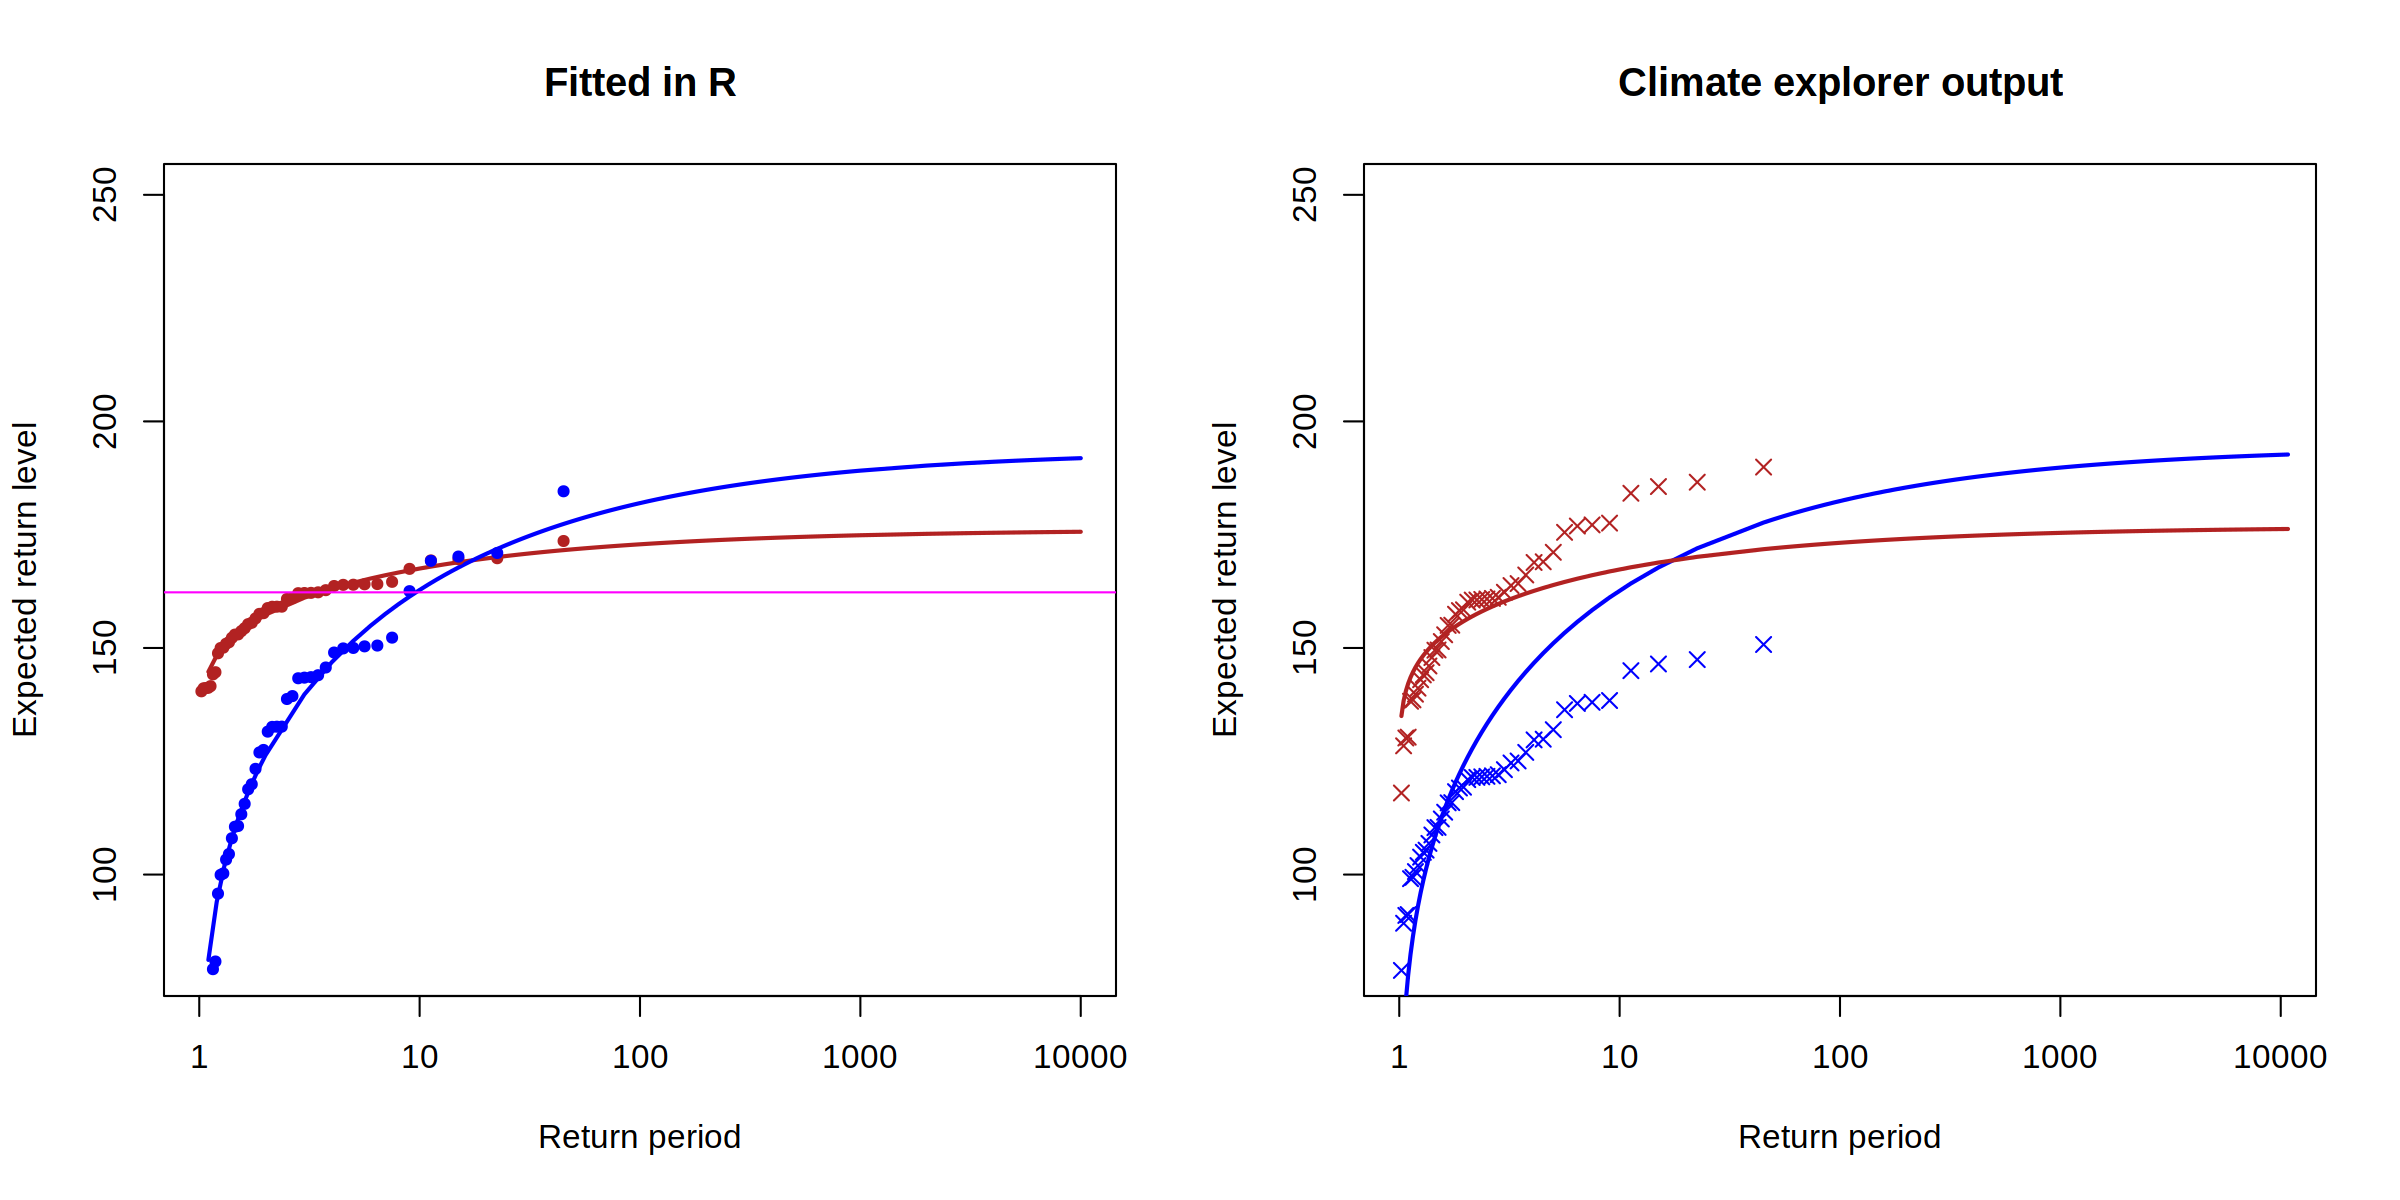

In [70]:
prep_window(c(1,2), h = 6, w = 6)
ylim <- c(80,250)
xlim <- c(1,10000)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

plot(0, type = "n", xlim = xlim, ylim = ylim, log = "x", ylab = "Expected return level", xlab = "Return period", main = "Fitted in R")
lines(rp_x, rl_curve_pres, col = "firebrick", lwd = 2)
lines(rp_x, rl_curve_cf, col = "blue", lwd = 2)

points(rp_th, sort(rl_obs_pres), col = "firebrick")
points(rp_th, sort(rl_obs_cf), col = "blue")

abline(h = ev, col = "magenta")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

plot(0, type = "n", xlim = xlim, ylim = ylim, log = "x", ylab = "Expected return level", xlab = "Return period", main = "Climate explorer output")

for (i in 1:2) {
    cx_i <- list(cx_cf, cx_f)[[i]]
    c <- c("blue", "firebrick")[i]
    
#     lines(cx_i[1:10,c("T", "fit")], col = c, lw = 1)
#     lines(cx_i[11:20,c("T", "fit")], col = c, lw = 1)
    points(cx_i[21+(0:44),c("T", "Y")], col = c, pch = 4)
    lines(cx_i[21+(0:95),c("T", "fit")], col = c, lw = 2)
}

In [7]:
# trying to fix the climate explorer code
df <- df
yy <- df$pr
zz <- df$gmst

alpha <- mdl_gev_ss_auto$results$par["mu1"]
beta <- mdl_gev_ss_auto$results$par["sigma1"]

cov <- unlist(cov_f)

In [8]:
qq <- yy - alpha * (zz - cov) / beta

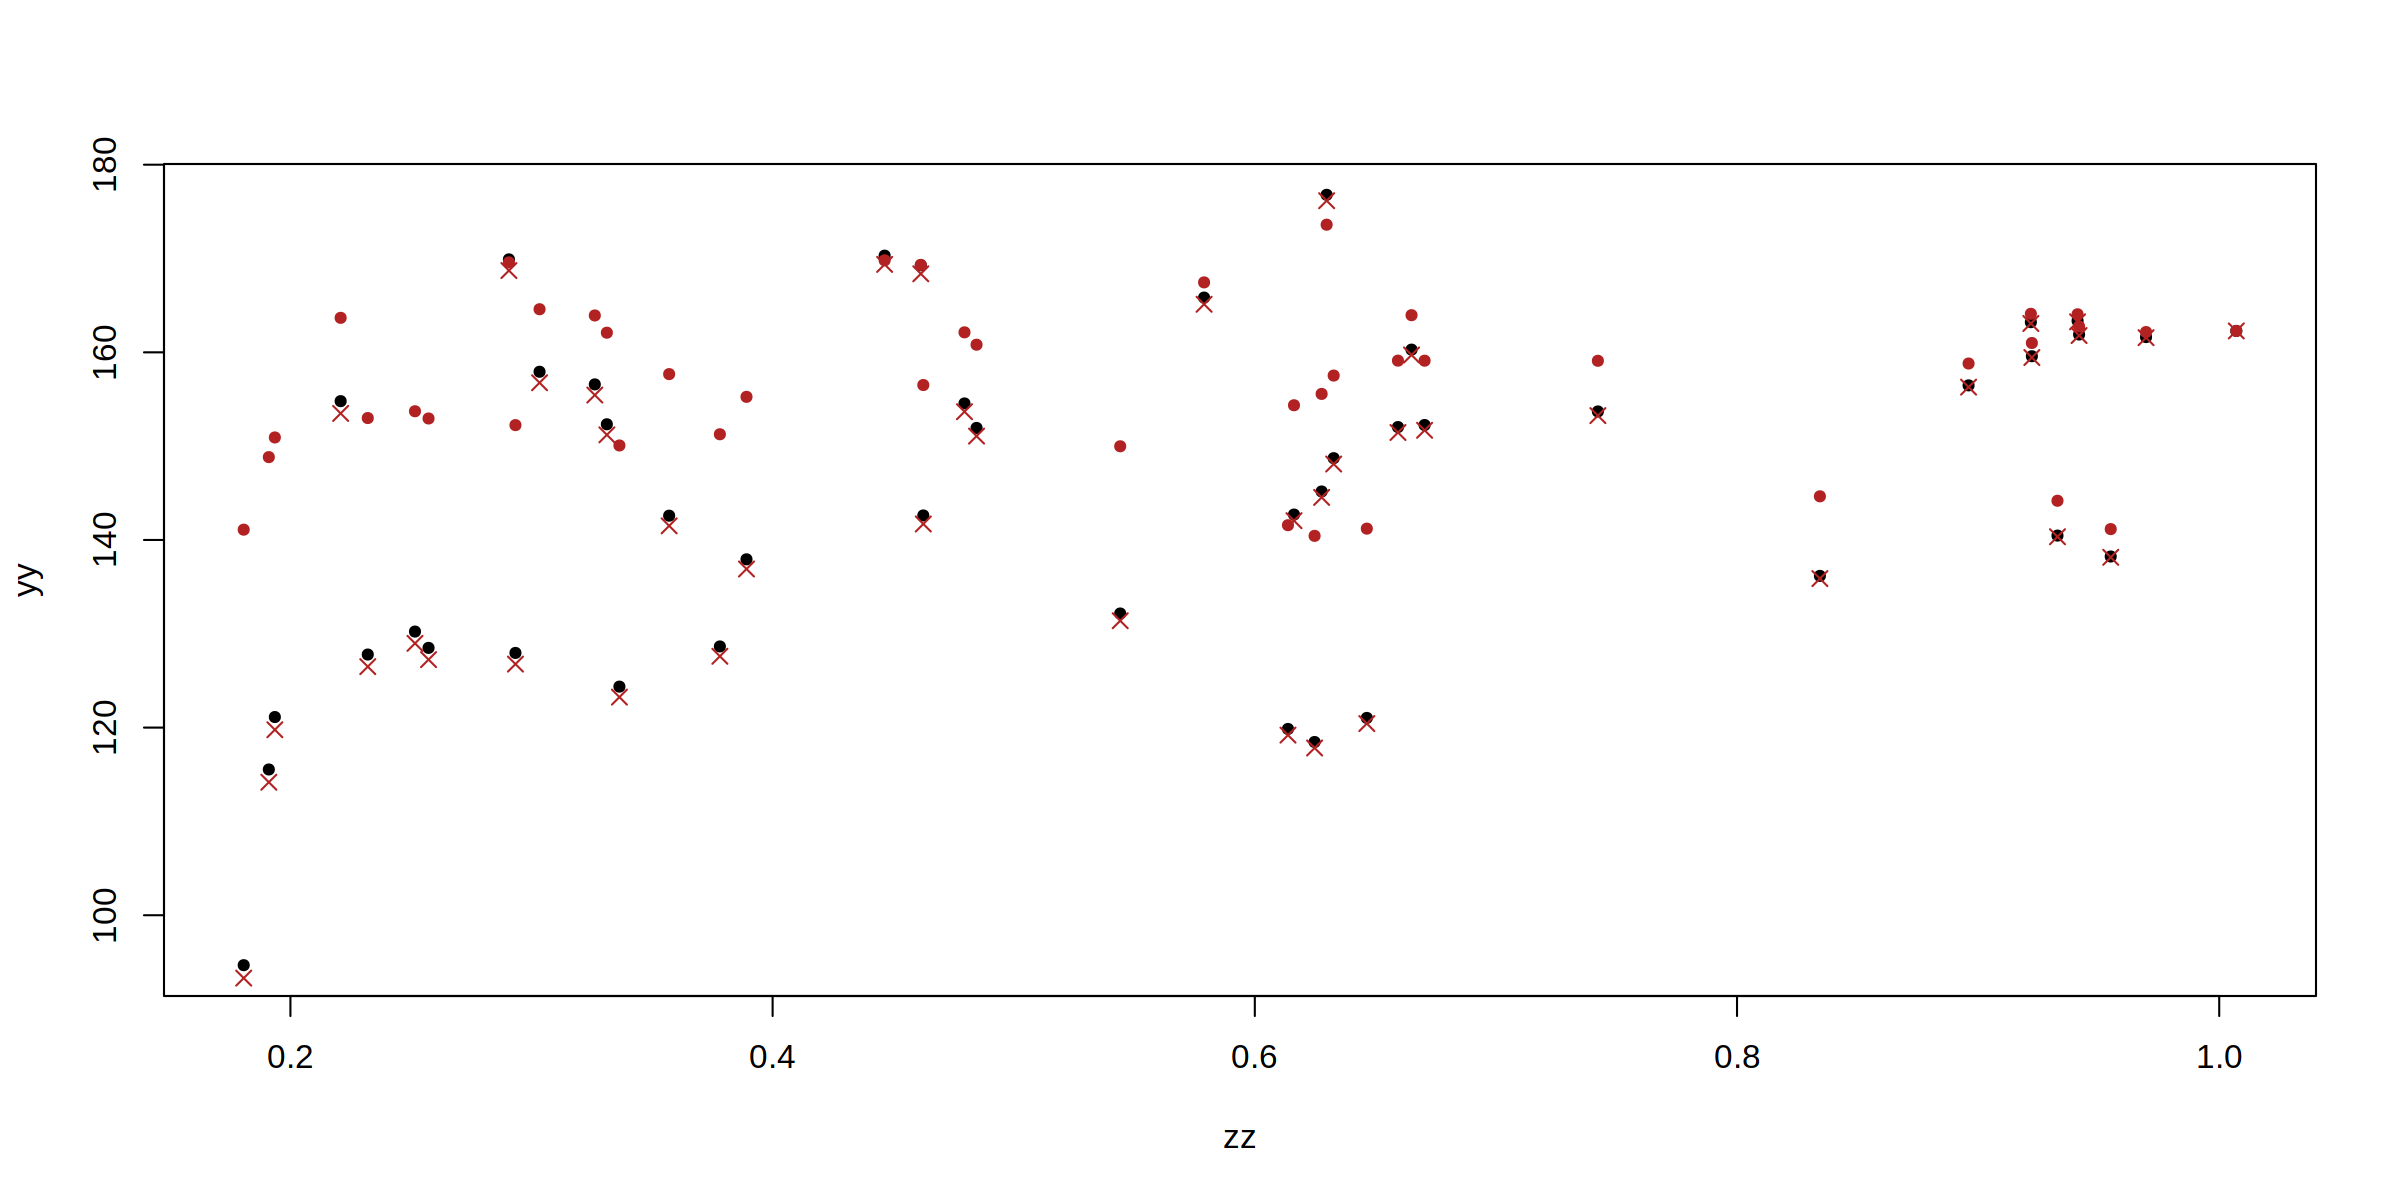

In [9]:
plot(zz, yy, pch = 20) # untransformed values
points(zz, rl_obs_pres, col = "firebrick", pch = 20) # correct values
points(zz, qq, col = "firebrick", pch = 4) # attempt at manually transforming values

In [10]:
# check transformation needed
mdl <- fit_ns("norm", "shiftscale", df, "pr", c("gmst"))

In [11]:
qevd(0.5, loc = mdl$par["mu0"] + mdl$par["alpha_gmst"] * cov_f$gmst, scale = mdl$par["sigma0"] + mdl$par["beta_gmst"] * cov_f$gmst, shape = mdl$par["shape"])

ERROR: Error in if (shape == 0 || type == "gumbel") q <- loc - scale * log(-log(p)) else q <- loc + : missing value where TRUE/FALSE needed


In [ ]:
qevd(0.7)

In [ ]:
qnorm(0.975)

In [ ]:
qnorm(0.975, mdl$par["mu0"] + mdl$par["alpha_gmst"] * cov_f$gmst, mdl$par["sigma0"] + mdl$par["beta_gmst"] * cov_f$gmst)

In [ ]:
mdl$par["mu0"] + mdl$par["alpha_gmst"] * cov_f$gmst + qnorm(0.975) * (mdl$par["sigma0"] + mdl$par["beta_gmst"] * cov_f$gmst)

In [ ]:
1/(1-0.975)

# `adjustyy` function

In [29]:
xx <- df[,c("pr", "gmst")]

In [39]:
a <- mdl_gev_ss_auto$results$par["mu0"]
alpha <- mdl_gev_ss_auto$results$par["mu1"]
b <- mdl_gev_ss_auto$results$par["sigma0"]
beta <- mdl_gev_ss_auto$results$par["sigma1"]
xi <- mdl_gev_ss_auto$results$par["shape"]

assume <- "both"
dist <- "gev"

In [66]:
get_return_period <- function(y,z,a,b,alpha,beta,xi,assume,dist) {
    
    # fix the location, scale & shape of the distribution using the parameters, covariates & assumed form
    if (assume == "shift") {
        loc = a + alpha*z
        scale = b
        shape = xi
    } else if (assume == "scale") {
        loc = a * exp(alpha*z / a)
        scale = b * exp(alpha*z / a)
        shape = xi
    } else if (assume == "both") {
        loc = a + alpha*z
        scale = b + beta*z
        shape = xi
    }
    
    # get the exceedance probability for the appropriate distribution & invert to get return period
    if (dist == "gau") {
        return (1/pnorm(y, mean = loc, sd = scale))
    } else if (dist == "gev") {
        return (1/pevd(y, loc = loc, scale = scale, shape = shape))
    }
}

In [67]:
get_return_level <- function(rp,z,a,b,alpha,beta,xi,assume,dist) {
    
    # fix the location, scale & shape of the distribution according to the parameters & covariates
    if (assume == "shift") {
        loc = a + alpha*z
        scale = b
        shape = xi
    } else if (assume == "scale") {
        loc = a * exp(alpha*z / a)
        scale = b * exp(alpha*z / a)
        shape = xi
    } else if (assume == "both") {
        loc = a + alpha*z
        scale = b + beta*z
        shape = xi
    }
    
    # invert the return level to get the exceedance probability, and find the associated return level for the appropriate distribution
    if (dist == "gau") {
        return (qnorm(1/rp, mean = loc, sd = scale))
    } else if (dist == "gev") {
        return (qevd(1/rp, loc = loc, scale = scale, shape = shape))
    }
}

In [68]:
adjust_yy <- function(xx,assume,a,b,alpha,beta,cov,dist) {
    
#    inputs as for current adjust_yy function: xx,assume,a,b,alpha,beta,cov
#    new input: dist (determines how to compute the return period & return level)
#    I've assumed that a and b are mu0 and sigma0
    
    # split data (xx) into obs (yy) and covariates (zz)
    yy <- xx[,1]
    zz <- xx[,2]

    # make an empty vector to hold transformed return levels
    rl <- c()
    
    # loop over each observation in turn
    for (i in 1:length(yy)) {
        
        # get the return period for that point at its own covariate (zz)
        rp <- get_return_period(yy[i], zz[i], a, b, alpha, beta, xi, assume, dist)
        
        # get the return level at the fixed covariate (cov) and add to the empty vector
        rl[i] <- get_return_level(rp, cov, a, b, alpha, beta, xi, assume, dist)
    }
    
    # return the vector of transformed return levels
    return(rl)
}

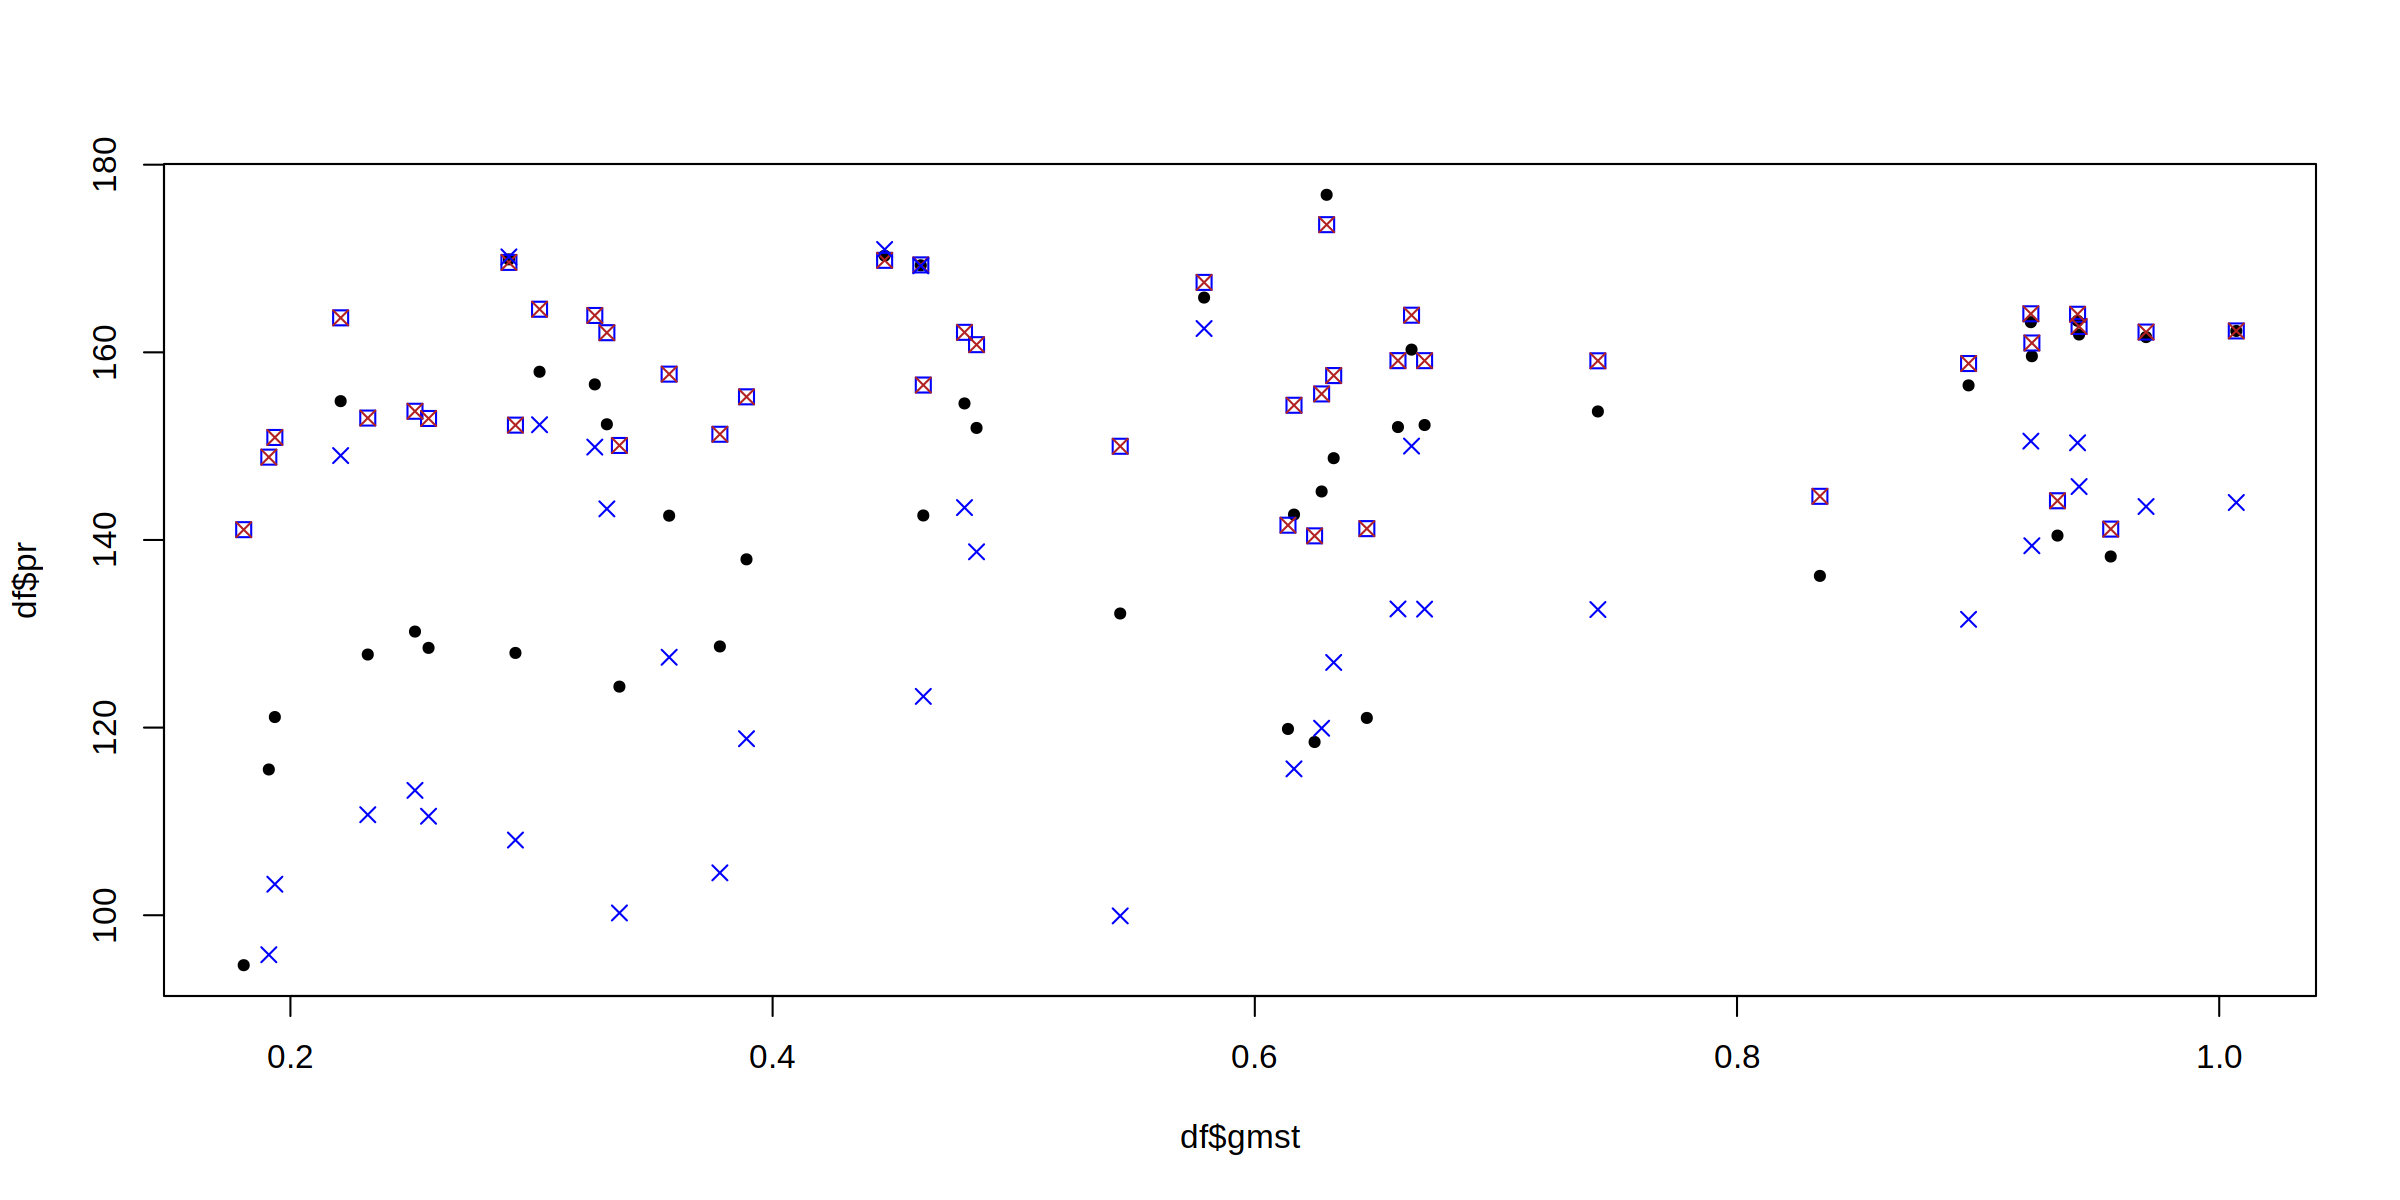

In [65]:
plot(df$gmst, df$pr, pch = 20) # untransformed values
points(df$gmst, rl_obs_pres, col = "blue", pch = 0) # correct values
points(df$gmst, adjust_yy(df[,c("pr", "gmst")], assume = "both", a,b,alpha,beta, cov = cov_f, dist = "gev"), col = "firebrick", pch = 4) # correct values
points(df$gmst, adjust_yy(df[,c("pr", "gmst")], assume = "both", a,b,alpha,beta, cov = cov_f-1.3, dist = "gev"), col = "blue", pch = 4) # correct values

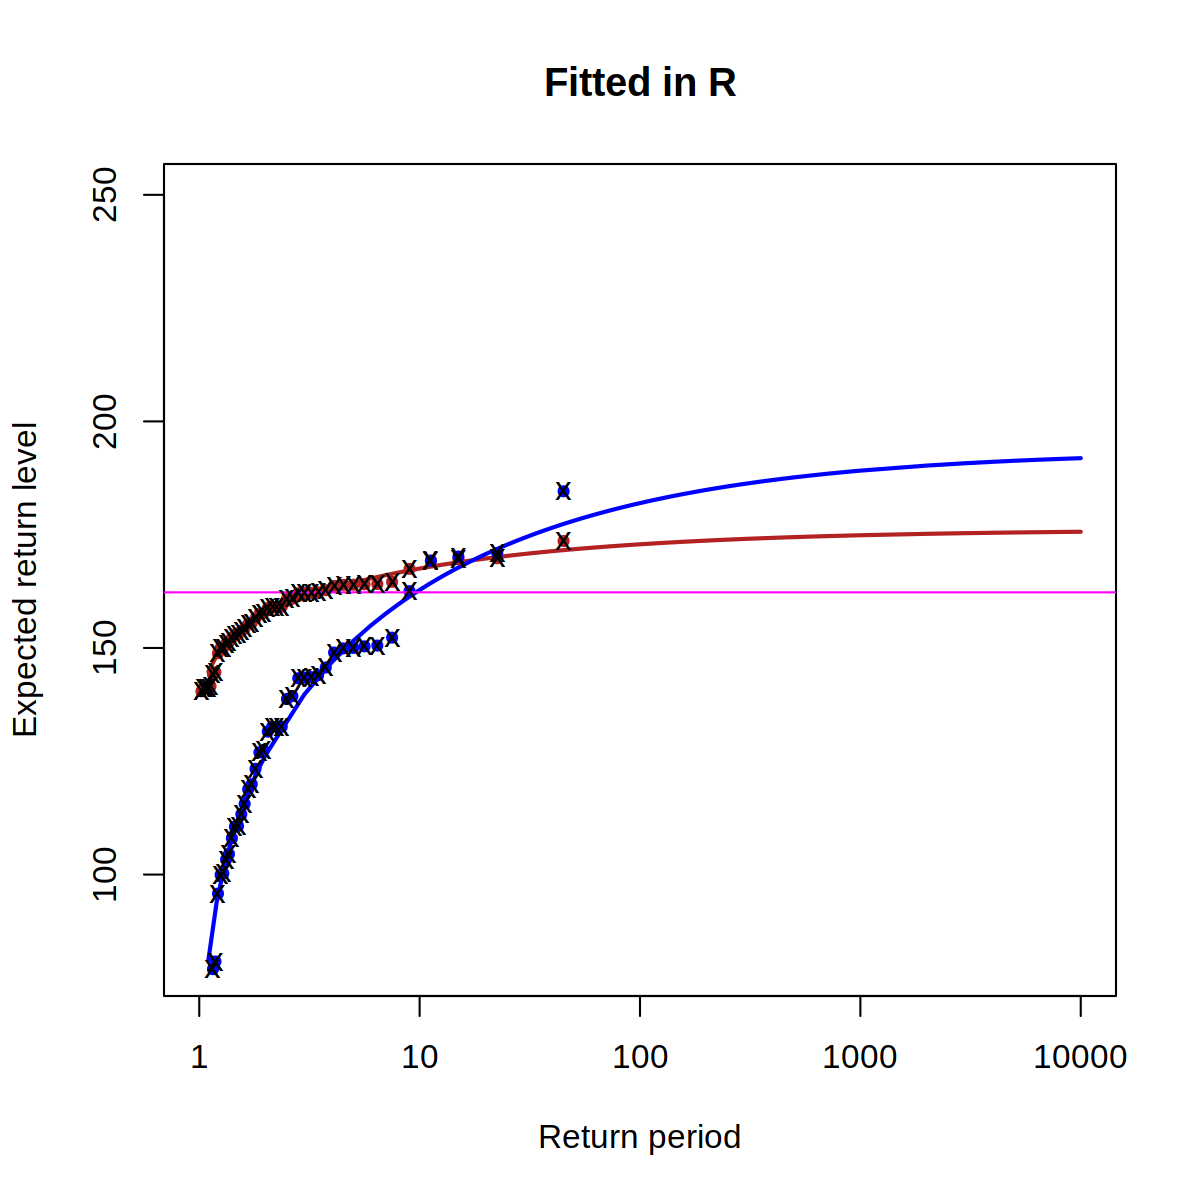

In [78]:
prep_window(c(1,1), h = 6, w = 6)
ylim <- c(80,250)
xlim <- c(1,10000)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

plot(0, type = "n", xlim = xlim, ylim = ylim, log = "x", ylab = "Expected return level", xlab = "Return period", main = "Fitted in R")
lines(rp_x, rl_curve_pres, col = "firebrick", lwd = 2)
lines(rp_x, rl_curve_cf, col = "blue", lwd = 2)

points(rp_th, sort(rl_obs_pres), col = "firebrick")
points(rp_th, sort(rl_obs_cf), col = "blue")

abline(h = ev, col = "magenta")

points(rp_th, sort(adjust_yy(df[,c("pr", "gmst")], assume = "both", a,b,alpha,beta, cov = unlist(cov_f), dist = "gev")), pch = "x")
points(rp_th, sort(adjust_yy(df[,c("pr", "gmst")], assume = "both", a,b,alpha,beta, cov = unlist(cov_f - 1.3), dist = "gev")), pch = "x")

In [75]:
unlist(adjust_yy(df[,c("pr", "gmst")], assume = "both", a,b,alpha,beta, cov = cov_f, dist = "gev"))

[1] 163.6765 152.9493 152.9944 141.0973 148.8304 150.9273 153.7187 169.5861
 [9] 157.6781 151.2663 150.0728 163.9293 152.2412 164.5937 162.0919 155.2555
[17] 156.5138 169.8062 169.3203 162.1299 160.8145 149.9856 167.4555 141.5745
[25] 154.3587 155.5669 173.6054 140.4375 141.2076 157.5239 159.1143 163.9590
[33] 159.1098 159.0972 144.6513 158.8061 164.1059 162.7550 164.0561 160.9948
[41] 144.1786 162.1612 141.1572 162.2800